## Multi-armed Bandits

In [1]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt

# For plotting figures inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.size'] = 13
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['legend.loc'] = 'lower right'
plt.rcParams['legend.fontsize'] = 13

### Utility function: argmax

In [2]:
def argmax(q_estimates):
    q_max = q_estimates[0]
    best_actions = [0]
    for i in range(1, len(q_estimates)):
        if q_estimates[i] > q_max:
            q_max = q_estimates[i]
            best_actions = [i]
        elif q_estimates[i] == q_max:
            best_actions.append(i)
    return np.random.choice(best_actions)

### The 10-armed Testbed

- True action values $\mu = q_*(a)$ are drawn/redrawn from a stanard normal distribution each time we run the testbed
- Reward is sampled from a normal distribution, with $\mu = q_*(a)$, $\sigma^2 = 1$

In [3]:
class Testbed:
    
    def __init__(self, arms, stationary=True):
        self.arms = arms
        self.stationary = stationary
        self.reset()

    def get_reward(self, action):
        if not self.stationary and self.count == 500: self.reset()
        self.count += 1
        return np.random.normal(self.q_actuals[action], 1)

    def reset(self):
        self.count = 0
        self.q_actuals = np.random.randn(self.arms)
        self.q_optimal = np.amax(self.q_actuals)
        self.optimal_action = np.argmax(self.q_actuals)

### Agent

In [4]:
class Agent:
    
    def __init__(self, arms, strategy, **params):
        self.arms = arms
        self.strategy = strategy
        self.params = params
        self.q_estimates = np.full(arms, params['init_val']) if 'init_val' in self.params else np.zeros(arms)
        self.action_counts = np.zeros(arms)

    def pull(self):
        if self.strategy == 'epsilon_greedy':
            epsilon = self.params['epsilon']
            if np.random.random_sample() < epsilon:
                action = np.random.randint(self.arms) # Explore
            else:
                action = argmax(self.q_estimates) # Exploit
            self.action_counts[action] += 1
        
        elif self.strategy == 'ucb':
            c = self.params['c']
            if 0 in self.action_counts:
                unused_arms = np.where(self.action_counts == 0)[0]
                action = np.random.choice(unused_arms)
            else:
                total_steps = np.sum(self.action_counts)
                ucb_terms = self.q_estimates + c * np.sqrt(np.log(total_steps)/self.action_counts)
                action = argmax(ucb_terms)
        
        self.action_counts[action] += 1
        
        return action

    def update_estimate(self, reward, action):
        if 'step_size' in self.params:
            step_size = self.params['step_size']
        else:
            step_size = 1 / self.action_counts[action]
        self.q_estimates[action] += step_size * (reward - self.q_estimates[action])

    def reset(self):
        self.q_estimates[:] = self.params['init_val'] if 'init_val' in self.params else 0.
        self.action_counts[:] = 0

### Environment

In [5]:
class Environment:

    def __init__(self, pulls, iterations, testbed):
        self.pulls = pulls
        self.iterations = iterations
        self.testbed = testbed

    def run(self, agent, testbed=None):
        if testbed is not None: self.testbed = testbed
        
        q_optimal_sum = 0.
        all_scores_avg = []
        optimal_counts = np.zeros(self.pulls)
        
        msg = f'{agent.strategy} agent with {agent.params}, stationarity={self.testbed.stationary}'
        print(msg)
        print('-'*len(msg))
    
        for i in range(self.iterations):
            # Set a random seed for each iteration/experiment
            np.random.seed(i)
            
            # Reset the testbed and agent
            self.testbed.reset()
            agent.reset()
            
            # Cumulative sum of optimal action-values over iterations/experiments
            q_optimal_sum += self.testbed.q_optimal
            
            # Choose actions through time-steps / Pull arms
            scores_sum = 0.
            scores_avg = []
            for p in range(self.pulls):
                # Pull an arm > get reward > update value-estimate
                action = agent.pull()
                reward = self.testbed.get_reward(action)
                agent.update_estimate(reward, action)

                # Store avg. reward at each time-step/pull
                scores_sum += reward
                scores_avg.append(scores_sum/(p+1))
                
                # Store total no. of optimal actions chosen (over iterations/experiments) at each time-step/pull
                if action == self.testbed.optimal_action:
                    optimal_counts[p] += 1
                    
            all_scores_avg.append(scores_avg)
            
            if i%100 == 99 or i == self.iterations-1:
                print(f'No. of iterations completed: {i+1}')
        
        q_optimal_avg = q_optimal_sum / self.iterations
        all_scores_avg = np.mean(all_scores_avg, axis=0)
        optimal_counts_avg = optimal_counts / self.iterations
        
        print()
        
        return q_optimal_avg, all_scores_avg, optimal_counts_avg

In [6]:
arms = 10  # no. of actions to choose from
pulls = 1000  # no. of pulls / time-steps in each run
iterations = 2000  # no. of iterations/experiments

# Initialize 10-armed testbed & environment
testbed  = Testbed(arms)
env = Environment(pulls, iterations, testbed)

### Agent with $\epsilon$-greedy action selection

In [7]:
eps = [0., 0.01, 0.1, 0.4]

all_scores_avgs = []
optimal_counts_avgs = []

for ep in eps:
    agent = Agent(arms, strategy='epsilon_greedy', epsilon=ep)
    q_optimal_avg, all_scores_avg, optimal_counts_avg = env.run(agent)
    
    all_scores_avgs.append(all_scores_avg)
    optimal_counts_avgs.append(optimal_counts_avg)

epsilon_greedy agent with {'epsilon': 0.0}, stationarity=True
-------------------------------------------------------------
No. of iterations completed: 100
No. of iterations completed: 200
No. of iterations completed: 300
No. of iterations completed: 400
No. of iterations completed: 500
No. of iterations completed: 600
No. of iterations completed: 700
No. of iterations completed: 800
No. of iterations completed: 900
No. of iterations completed: 1000
No. of iterations completed: 1100
No. of iterations completed: 1200
No. of iterations completed: 1300
No. of iterations completed: 1400
No. of iterations completed: 1500
No. of iterations completed: 1600
No. of iterations completed: 1700
No. of iterations completed: 1800
No. of iterations completed: 1900
No. of iterations completed: 2000

epsilon_greedy agent with {'epsilon': 0.01}, stationarity=True
--------------------------------------------------------------
No. of iterations completed: 100
No. of iterations completed: 200
No. of itera

### Compare $\epsilon$-greedy agents with different $\epsilon$ values

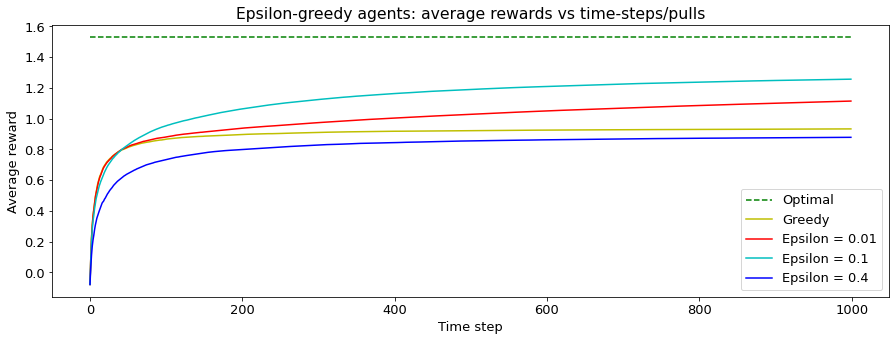

In [8]:
# Plot rewards averaged over runs (iters) vs time-steps/pulls
plt.plot([q_optimal_avg for _ in range(len(all_scores_avgs[0]))], color='g', linestyle='--')
plt.plot(all_scores_avgs[0], color='y')
plt.plot(all_scores_avgs[1], color='r')
plt.plot(all_scores_avgs[2], color='c')
plt.plot(all_scores_avgs[3], color='b')
plt.title('Epsilon-greedy agents: average rewards vs time-steps/pulls')
plt.xlabel('Time step')
plt.ylabel('Average reward')
plt.legend(['Optimal', 'Greedy', f'Epsilon = {eps[1]}', f'Epsilon = {eps[2]}', f'Epsilon = {eps[3]}'])

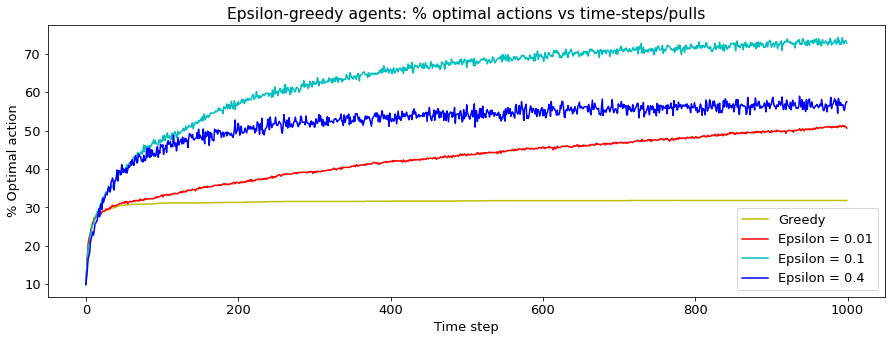

In [9]:
# Plot optimal action counts averaged over runs (iters) vs time-steps/pulls
plt.plot(optimal_counts_avgs[0]*100, color='y')
plt.plot(optimal_counts_avgs[1]*100, color='r')
plt.plot(optimal_counts_avgs[2]*100, color='c')
plt.plot(optimal_counts_avgs[3]*100, color='b')
plt.title('Epsilon-greedy agents: % optimal actions vs time-steps/pulls')
plt.xlabel('Time step')
plt.ylabel('% Optimal action')
plt.legend(['Greedy', f'Epsilon = {eps[1]}', f'Epsilon = {eps[2]}', f'Epsilon = {eps[3]}'])

### Effect of Optimistic Initial Value

In [10]:
agent = Agent(arms, strategy='epsilon_greedy', epsilon=0., step_size=0.1, init_val=5.)
_, _, optimal_counts_avg_1 = env.run(agent)

epsilon_greedy agent with {'epsilon': 0.0, 'step_size': 0.1, 'init_val': 5.0}, stationarity=True
------------------------------------------------------------------------------------------------
No. of iterations completed: 100
No. of iterations completed: 200
No. of iterations completed: 300
No. of iterations completed: 400
No. of iterations completed: 500
No. of iterations completed: 600
No. of iterations completed: 700
No. of iterations completed: 800
No. of iterations completed: 900
No. of iterations completed: 1000
No. of iterations completed: 1100
No. of iterations completed: 1200
No. of iterations completed: 1300
No. of iterations completed: 1400
No. of iterations completed: 1500
No. of iterations completed: 1600
No. of iterations completed: 1700
No. of iterations completed: 1800
No. of iterations completed: 1900
No. of iterations completed: 2000



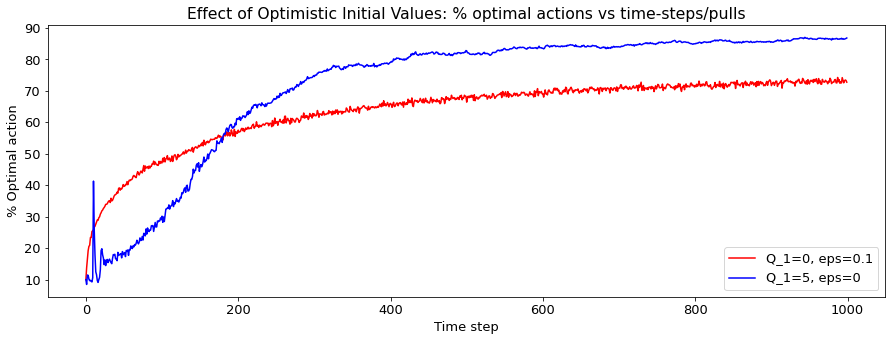

In [11]:
# Plot optimal action counts averaged over runs (iters) vs time-steps/pulls
plt.plot(optimal_counts_avgs[2]*100, color='r')
plt.plot(optimal_counts_avg_1*100, color='b')
plt.title('Effect of Optimistic Initial Values: % optimal actions vs time-steps/pulls')
plt.xlabel('Time step')
plt.ylabel('% Optimal action')
plt.legend(['Q_1=0, eps=0.1', 'Q_1=5, eps=0'])

### Non-stationary bandit problem

In [12]:
testbed_ns  = Testbed(arms, stationary=False)

agent_1 = Agent(arms, strategy='epsilon_greedy', epsilon=0.1)
agent_2 = Agent(arms, strategy='epsilon_greedy', epsilon=0.1, step_size=0.1)

_, all_scores_avg_2, _ = env.run(agent_1, testbed_ns) # Pass new testbed
_, all_scores_avg_3, _ = env.run(agent_2)

epsilon_greedy agent with {'epsilon': 0.1}, stationarity=False
--------------------------------------------------------------
No. of iterations completed: 100
No. of iterations completed: 200
No. of iterations completed: 300
No. of iterations completed: 400
No. of iterations completed: 500
No. of iterations completed: 600
No. of iterations completed: 700
No. of iterations completed: 800
No. of iterations completed: 900
No. of iterations completed: 1000
No. of iterations completed: 1100
No. of iterations completed: 1200
No. of iterations completed: 1300
No. of iterations completed: 1400
No. of iterations completed: 1500
No. of iterations completed: 1600
No. of iterations completed: 1700
No. of iterations completed: 1800
No. of iterations completed: 1900
No. of iterations completed: 2000

epsilon_greedy agent with {'epsilon': 0.1, 'step_size': 0.1}, stationarity=False
--------------------------------------------------------------------------------
No. of iterations completed: 100
No. of 

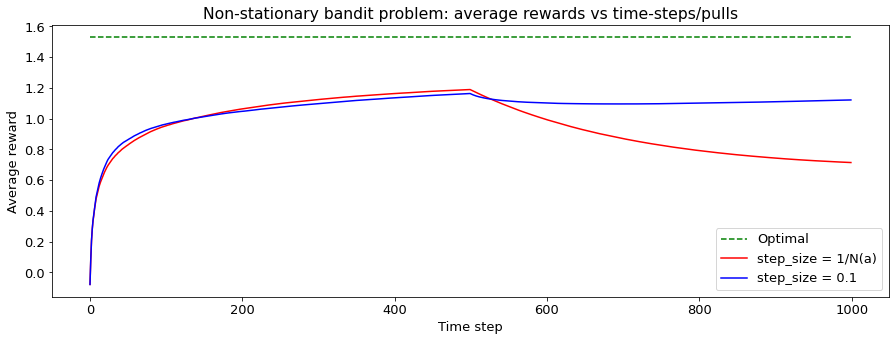

In [13]:
# Plot rewards averaged over runs (iters) vs time-steps/pulls
plt.plot([q_optimal_avg for _ in range(len(all_scores_avg_2))], color='g', linestyle='--')
plt.plot(all_scores_avg_2, color='r')
plt.plot(all_scores_avg_3, color='b')
plt.title('Non-stationary bandit problem: average rewards vs time-steps/pulls')
plt.xlabel('Time step')
plt.ylabel('Average reward')
plt.legend(['Optimal', 'step_size = 1/N(a)', 'step_size = 0.1'])

### Agent with UCB action selection

In [14]:
all_scores_avgs_1 = []
optimal_counts_avgs_1 = []

for v in [1, 2]:
    agent = Agent(arms, strategy='ucb', c=v)
    _, all_scores_avg, optimal_counts_avg = env.run(agent, testbed)

    all_scores_avgs_1.append(all_scores_avg)
    optimal_counts_avgs_1.append(optimal_counts_avg)

ucb agent with {'c': 1}, stationarity=True
------------------------------------------
No. of iterations completed: 100
No. of iterations completed: 200
No. of iterations completed: 300
No. of iterations completed: 400
No. of iterations completed: 500
No. of iterations completed: 600
No. of iterations completed: 700
No. of iterations completed: 800
No. of iterations completed: 900
No. of iterations completed: 1000
No. of iterations completed: 1100
No. of iterations completed: 1200
No. of iterations completed: 1300
No. of iterations completed: 1400
No. of iterations completed: 1500
No. of iterations completed: 1600
No. of iterations completed: 1700
No. of iterations completed: 1800
No. of iterations completed: 1900
No. of iterations completed: 2000

ucb agent with {'c': 2}, stationarity=True
------------------------------------------
No. of iterations completed: 100
No. of iterations completed: 200
No. of iterations completed: 300
No. of iterations completed: 400
No. of iterations comple

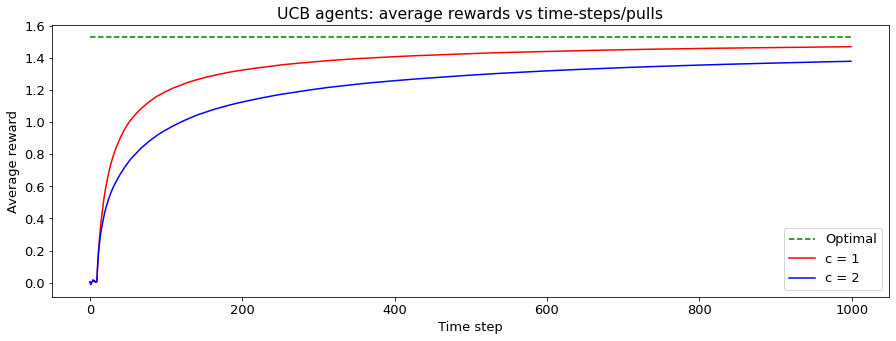

In [15]:
# Plot rewards averaged over runs (iters) vs time-steps/pulls
plt.plot([q_optimal_avg for _ in range(len(all_scores_avgs_1[0]))], color='g', linestyle='--')
plt.plot(all_scores_avgs_1[0], color='r')
plt.plot(all_scores_avgs_1[1], color='b')
plt.title('UCB agents: average rewards vs time-steps/pulls')
plt.xlabel('Time step')
plt.ylabel('Average reward')
plt.legend(['Optimal', 'c = 1', 'c = 2'])

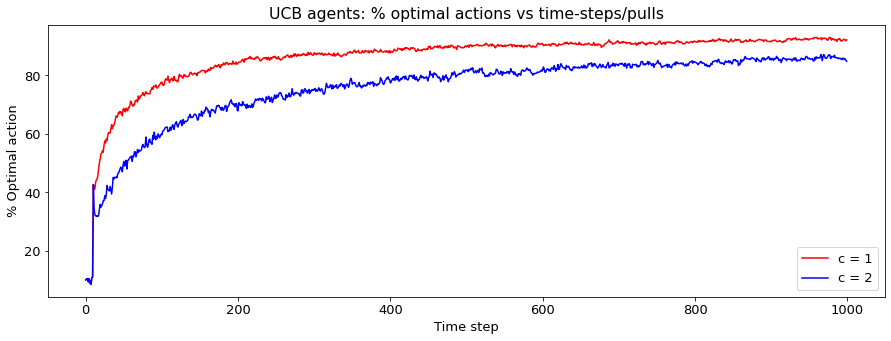

In [16]:
# Plot optimal action counts averaged over runs (iters) vs time-steps/pulls
plt.plot(optimal_counts_avgs_1[0]*100, color='r')
plt.plot(optimal_counts_avgs_1[1]*100, color='b')
plt.title('UCB agents: % optimal actions vs time-steps/pulls')
plt.xlabel('Time step')
plt.ylabel('% Optimal action')
plt.legend(['c = 1', 'c = 2'])

### Compare UCB with $\epsilon$-greedy action selection

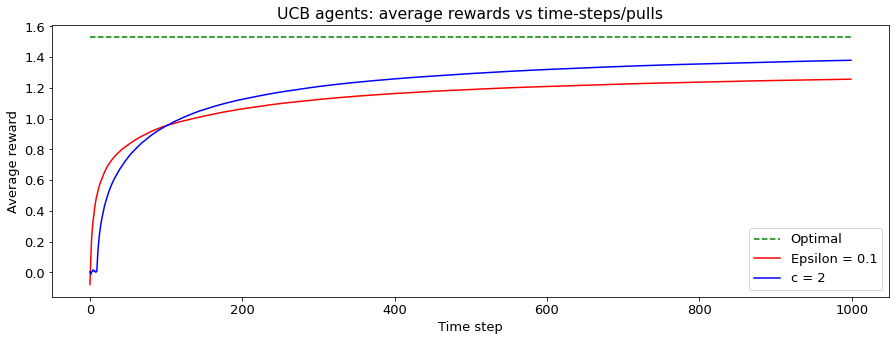

In [17]:
# Plot rewards averaged over runs (iters) vs time-steps/pulls
plt.plot([q_optimal_avg for _ in range(len(all_scores_avgs_1[0]))], color='g', linestyle='--')
plt.plot(all_scores_avgs[2], color='r')
plt.plot(all_scores_avgs_1[1], color='b')
plt.title('UCB agents: average rewards vs time-steps/pulls')
plt.xlabel('Time step')
plt.ylabel('Average reward')
plt.legend(['Optimal', f'Epsilon = {eps[2]}', 'c = 2'])

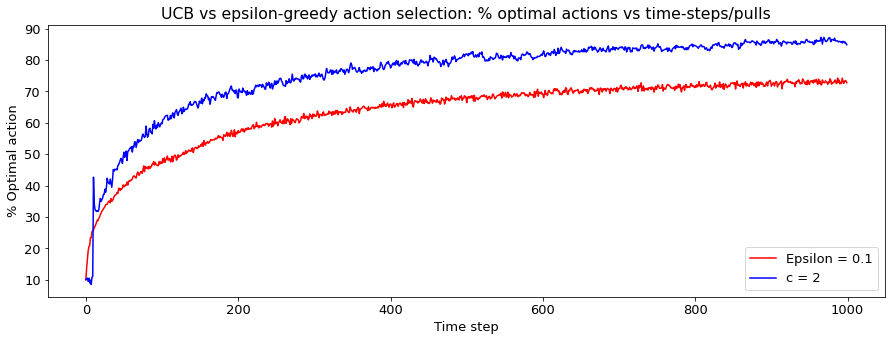

In [18]:
# Plot optimal action counts averaged over runs (iters) vs no. of time-steps/pulls
plt.plot(optimal_counts_avgs[2]*100, color='r')
plt.plot(optimal_counts_avgs_1[1]*100, color='b')
plt.title('UCB vs epsilon-greedy action selection: % optimal actions vs time-steps/pulls')
plt.xlabel('Time step')
plt.ylabel('% Optimal action')
plt.legend([f'Epsilon = {eps[2]}', 'c = 2'])